In [1]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import gzip
import json
import sys
import re

%matplotlib inline

### Parser sobre o arquivo de entrada ``amazon-meta.txt.gz`` para gerar um JSON com a estrutura do produto

In [2]:
def get_line_number(file_path):
    sys.stderr.write("Counting line number of {}".format(file_path))
    
    with gzip.open(file_path, 'rb') as file:
        for lines, l in enumerate(file):
            pass
        
    return lines

In [3]:
def parser(filename, total):
    IGNORE_FIELDS = ['Total items', 'reviews']
    f = gzip.open(filename, 'r')
    entry = {}
    categories = []
    reviews = []
    similar_items = []
    
    for line in tqdm(f, total=total):
        line = line.decode("utf-8").strip()
        colonPos = line.find(':')
        
        if line.startswith("Id"):
            if reviews:
                entry["reviews"] = reviews
            if categories:
                entry["categories"] = categories
            
            yield entry
            entry = {}
            categories = []
            reviews = []
            rest = line[colonPos+2:]
            entry["id"] = rest.strip()
        
        elif line.startswith("similar"):
            similar_items = line.split()[2:]
            entry['similar_items'] = similar_items
            
        elif line.find("cutomer:") != -1:
            review_info = line.split()
            reviews.append({'data': review_info[0],'customer_id': review_info[2],'rating': int(review_info[4]),'votes': int(review_info[6]),'helpful': int(review_info[8])})
            
        elif line.startswith("|"):
            categories.append(line)
            
        elif colonPos != -1:
            eName = line[:colonPos]
            rest = line[colonPos+2:]
            
            if not eName in IGNORE_FIELDS:
                entry[eName] = rest.strip()
                
    if reviews:
        entry["reviews"] = reviews
        
    if categories:
        entry["categories"] = categories
        
    yield entry

In [4]:
path_file = 'amazon-meta.txt.gz'

In [5]:
line_num = get_line_number(path_file)

Counting line number of amazon-meta.txt.gz

In [6]:
with open('amazon-meta.json', 'w') as f:
    for e in parser(path_file, total=line_num):
        if e:
            json.dump(e, f)
            f.write('\n')

15010574it [01:56, 128894.06it/s]                              


# Consultas

In [2]:
conf = SparkConf().setMaster("local").set('spark.driver.cores',4).setAppName("Trabalho2_bd-PARTE_A")
sc = SparkContext(conf = conf)

In [3]:
path_file = 'amazon-meta.json'
text_file = sc.textFile(path_file)

## (a) Dado produto, listar os 5 comentários mais úteis e com maior avaliação e os 5 comentários mais úteis e com menor avaliação

In [4]:
# id do produto
id = 121345

In [5]:
def filter_id(rdd):
    json_temp = json.loads(rdd)
    if(json_temp['id'] == str(id)):
        return json_temp

product = text_file.filter(filter_id)

A ideia nessa questão é pegar os comentários mais úteis e ordenar, então na função ``map_comentarios`` foi feito uma tupla com 3 campos:
- quantidades de votos úteis que o review recebeu
- quantidades de votos que o review recebeu
- campo review

Por fim foi feita a ordenação pelo pelos campos (x[0],x[1]).

In [6]:
def map_comentarios(rdd):
    json_temp = json.loads(rdd)
    
    try:
        tmp = [(review['helpful'],review['votes'],review) for review in json_temp['reviews']]
        return sorted(tmp, key=lambda x: (x[0],x[1]), reverse=True)
    except:
        return []

reviews_product_sorted = product.map(map_comentarios).flatMap(lambda x: x).map(lambda x: x[2])

In [7]:
# 5 comentários mais uteis e com maior avaliação
reviews_product_sorted.collect()[:5]

[{'data': '2003-2-22',
  'customer_id': 'A12S8UQEIPZJKE',
  'rating': 5,
  'votes': 11,
  'helpful': 9},
 {'data': '2002-10-14',
  'customer_id': 'A2TF68WOCTVOML',
  'rating': 5,
  'votes': 8,
  'helpful': 5},
 {'data': '2003-10-24',
  'customer_id': 'A1VWSR1H2Y67UD',
  'rating': 5,
  'votes': 7,
  'helpful': 4},
 {'data': '2002-10-14',
  'customer_id': 'A2TF68WOCTVOML',
  'rating': 5,
  'votes': 8,
  'helpful': 3},
 {'data': '2005-1-6',
  'customer_id': 'A126YLPKFPNQDS',
  'rating': 2,
  'votes': 3,
  'helpful': 1}]

## (b) Dado um produto, listar os produtos similares com maiores vendas do que ele

In [27]:
# id do produto
id = 7177

In [28]:
def filter_id(rdd):
    json_temp = json.loads(rdd)
    if(json_temp['id'] == str(id)):
        return json_temp

filter_similar = text_file.filter(filter_id)

Na função ``pair_salesrank_similar`` faz um par com dois campos:
- similares
- salesrank (ranking de venda)

In [29]:
def pair_salesrank_similar(rdd):
    json_temp = json.loads(rdd)
    
    try:
        list_similar = [product for product in json_temp['similar_items']]
        return [(similar, int(json_temp['salesrank'])) for similar in list_similar]
    except:
        return []

pair_salesrank_similar = filter_similar.map(pair_salesrank_similar).flatMap(lambda x: x).filter(lambda x: len(x) > 0)

Então nesse passo é pegar os produtos da lista de similares que já temos, a variável ``join`` guarda essa informação

In [30]:
def map_asin_product(rdd):
    json_temp = json.loads(rdd)
    
    return (json_temp['ASIN'], json_temp)

map_asin_product = text_file.map(map_asin_product)
join = map_asin_product.join(pair_salesrank_similar)

Por fim filtrar os produtos similares que tem maior venda que o produto dado pelo campo ``salesrank``

In [31]:
def filter_maiores(rdd):
    list_temp = list(rdd)
    
    if(int(rdd[1][0]['salesrank']) > rdd[1][1]):
        return list_temp
    
filter_maiores = join.filter(filter_maiores)

In [32]:
def maiores(rdd):
    list_temp = list(rdd)
    
    return list_temp[1][0]

maiores = filter_maiores.map(maiores)

In [33]:
maiores.collect()

[{'id': '31028',
  'ASIN': 'B000002KFD',
  'title': 'Walking Man',
  'group': 'Music',
  'salesrank': '40320',
  'similar_items': ['B000002KG8',
   'B000002KFT',
   'B000002LHW',
   'B00000CKZH',
   'B00004SVK6'],
  'categories': ['|Music[5174]|Styles[301668]|Pop[37]|Singer-Songwriters[67176]',
   '|Music[5174]|Styles[301668]|Pop[37]|Soft Rock[67177]',
   '|Music[5174]|Styles[301668]|Rock[40]|Folk Rock[67205]',
   '|Music[5174]|Styles[301668]|Pop[37]|Adult Contemporary[67167]|General[468116]',
   "|Music[5174]|Formats[468038]|Today's Deals in Music[287454]|Pop[883128]|Adult Contemporary[883360]|CDs $7 - $10[519698]",
   "|Music[5174]|Formats[468038]|Today's Deals in Music[287454]|Pop[883128]|Singer-Songwriters[883370]|CDs $7 - $10[519706]",
   "|Music[5174]|Formats[468038]|Today's Deals in Music[287454]|Pop[883128]|Soft Rock[883372]|CDs $7 - $10[519708]",
   "|Music[5174]|Formats[468038]|Today's Deals in Music[287454]|Rock[883134]|Folk Rock[883394]|CDs $7 - $10[519752]",
   '|[265523]|

## (c) Dado um produto, mostrar a evolução diária das médias de avaliação ao longo do intervalo de tempo coberto no arquivo de entrada

In [1477]:
# id do produto
id = 416378

In [1478]:
def filter_id(rdd):
    json_temp = json.loads(rdd)
    if(json_temp['id'] == str(id)):
        return json_temp

filter_similar = text_file.filter(filter_id)

Depois de filtar pegar o produto o próximo passo é pegar as avaliações

In [1479]:
def map_data_rating(rdd):
    json_temp = json.loads(rdd)
    
    try:
        tmp = [[review['data'], review['rating']] for review in json_temp['reviews']]
        return sorted(tmp, key=lambda x: x[0], reverse=False)
    except:
        return []

map_data_rating = filter_similar.map(map_data_rating)

Daqui em diante é só plotar os dados

In [1480]:
list_data_rating = map_data_rating.collect()[0]
date_time_transf = [(list_data_rating[i][0].split('-')[0],list_data_rating[i][0].split('-')[1],list_data_rating[i][0].split('-')[2]) for i in range(len(list_data_rating))]
date_time = sorted([datetime.datetime(int(i[0]),int(i[1]),int(i[2])) for i in date_time_transf])

for i in range(len(list_data_rating)):
    list_data_rating[i][0] = date_time[i]
    
x = [date_time[0] for date_time in list_data_rating]
y = [date_time[1] for date_time in list_data_rating]

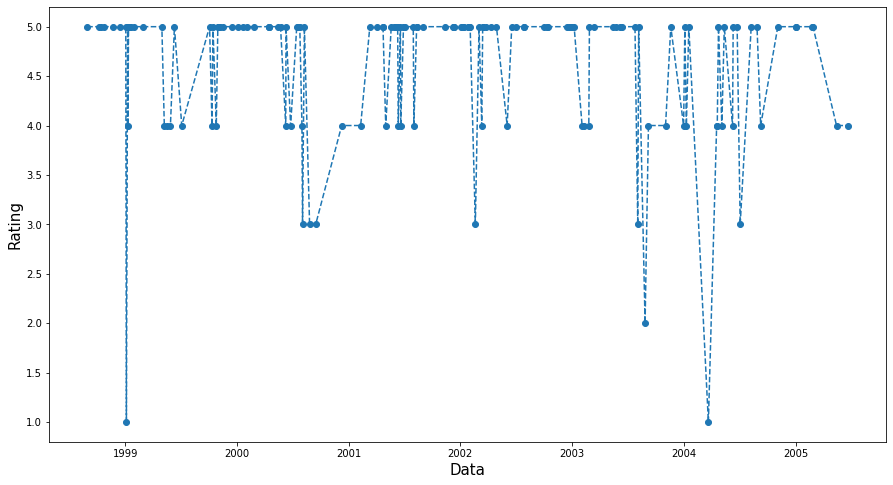

In [1481]:
plt.figure(figsize=(15,8))
plt.plot(x,y,'o--')
plt.xlabel('Data',fontsize=15)
plt.ylabel('Rating',fontsize=15)
plt.show()

#caso não tenha plotado nenhum ponto é porque o produto não tem review

## (d) Listar os 10 produtos lideres de venda em cada grupo de produtos

In [22]:
def filter_salesrank(rdd):
    json_temp = json.loads(rdd)
    
    try:
        if(int(json_temp['salesrank']) > 0):
            return json_temp
    except:
        pass

filter_salesrank = text_file.filter(filter_salesrank)

In [23]:
def map_groups(rdd):
    json_temp = json.loads(rdd)
    
    try:
        return (json_temp['group'],json_temp)
    except:
        return ('lixo','')

map_groups = filter_salesrank.map(map_groups).groupByKey()

In [24]:
def products_by_group_sorted(rdd):
    group = list(rdd)
    products = list(group[1])
    
    if(group[0] != 'lixo'):
        return (group[0], sorted(products, key=lambda k: int(k['salesrank']), reverse=False)[:10])
    else:
        return group
    
products_by_group_sorted = map_groups.map(products_by_group_sorted).filter(lambda x: x[0] != 'lixo')

In [26]:
products_by_group_sorted.collect()

[('Music',
  [{'id': '370604',
    'ASIN': 'B00004S36S',
    'title': 'Buzz Buzz',
    'group': 'Music',
    'salesrank': '27',
    'similar_items': ['B00004S36U',
     'B00004SR1J',
     'B00006JKGN',
     'B00005R26T',
     'B0000CC85J'],
    'categories': ["|Music[5174]|Styles[301668]|Children's Music[173425]|General[173426]"],
    'reviews': [{'data': '2000-3-8',
      'customer_id': 'A3KY3M74N2WPL9',
      'rating': 5,
      'votes': 9,
      'helpful': 9},
     {'data': '2000-3-20',
      'customer_id': 'A1OBYSLY3LAB67',
      'rating': 5,
      'votes': 1,
      'helpful': 1},
     {'data': '2000-3-28',
      'customer_id': 'A2HYAUD535SKON',
      'rating': 5,
      'votes': 6,
      'helpful': 6},
     {'data': '2000-4-19',
      'customer_id': 'A3KNL37N3NABUN',
      'rating': 5,
      'votes': 3,
      'helpful': 2},
     {'data': '2000-12-10',
      'customer_id': 'ATVPDKIKX0DER',
      'rating': 5,
      'votes': 6,
      'helpful': 3},
     {'data': '2001-1-2',
      'cust

## (e) Listar os 10 produtos com a maior média de avaliações úteis positivas por produto

In [1485]:
def pair_product_reviews(rdd):
    json_temp = json.loads(rdd)
    
    try:
        return (json_temp,json_temp['reviews'])
    except:
        return (json_temp,0)

pair_product_reviews = text_file.map(pair_product_reviews)

In [1486]:
def pair_product_avg(rdd):
    list_temp = list(rdd)
    
    if(list_temp[1] != 0):
        list_reviews = [reviews for reviews in list_temp[1]]
        list_temp[1] = sum([review['helpful'] for review in list_reviews]) / len(list_reviews)
    
    return list_temp

pair_product_avg = pair_product_reviews.map(pair_product_avg)
pair_product_avg_sorted = pair_product_avg.sortBy(lambda pair:pair[1],ascending=False)

In [1487]:
pair_product_avg_sorted.take(10)

[[{'id': '380551',
   'ASIN': '0967699703',
   'title': 'Understanding Loved Boys and Boylovers',
   'group': 'Book',
   'salesrank': '276987',
   'similar_items': [],
   'categories': ['|Books[283155]|Subjects[1000]|Gay & Lesbian[301889]|Nonfiction[10703]|General[10716]',
    '|Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|General[11289]'],
   'reviews': [{'data': '2000-5-29',
     'customer_id': 'A2MRE47JWXM0VD',
     'rating': 1,
     'votes': 445,
     'helpful': 378},
    {'data': '2000-6-4',
     'customer_id': 'A3MQOWM3HOZ639',
     'rating': 5,
     'votes': 243,
     'helpful': 50},
    {'data': '2000-6-7',
     'customer_id': 'A31BWOBKLGQP9F',
     'rating': 1,
     'votes': 645,
     'helpful': 555},
    {'data': '2000-6-8',
     'customer_id': 'A3HKKBOA57HE60',
     'rating': 5,
     'votes': 511,
     'helpful': 81},
    {'data': '2003-4-3',
     'customer_id': 'A20BPRGO03DSC1',
     'rating': 1,
     'votes': 187,
     'helpful': 151}

## (f) Listar a 5 categorias de produto com a maior média de avaliações úteis positivas por produto

In [9]:
def map_groups(rdd):
    json_temp = json.loads(rdd)
    
    try:
        return (json_temp['group'],json_temp['reviews'])
    except:
        return ('lixo',0)

map_groups = text_file.map(map_groups).groupByKey().filter(lambda x: x[0] != 'lixo')

In [10]:
def pair_group_avg_sorted(rdd):
    list_temp = list(rdd)
    
    acc = 0
    qtd = 0
    
    for reviews in list_temp[1]:
        for review in reviews:
            acc += review['helpful']
            qtd +=1
    
    return (list_temp[0], acc/qtd)

pair_group_avg_sorted = map_groups.map(pair_group_avg_sorted).sortBy(lambda x: x[1], ascending=False)

In [11]:
pair_group_avg_sorted.take(5)

[('Baby Product', 29.333333333333332),
 ('Sports', 27.2),
 ('Toy', 21.972972972972972),
 ('Software', 17.46153846153846),
 ('Video Games', 15.333333333333334)]

## (g) Listar os 10 clientes que mais fizeram comentários por grupo de produto

In [657]:
def map_groups(rdd):
    json_temp = json.loads(rdd)
    
    try:
        return (json_temp['group'],json_temp['reviews'])
    except:
        return ('lixo','')

map_groups = text_file.map(map_groups)

In [659]:
def pair_group_customer(rdd):
    list_temp = tuple(rdd)
    
    if(len(list_temp) > 0):
        return (list_temp[0], [review['customer_id'] for review in list_temp[1]])
    
    return (list_temp[0], 0)

pair_group_customer = map_groups.map(pair_group_customer).groupByKey()

In [670]:
def pair_group_costumer_count_sorted(rdd):
    list_temp = tuple(rdd)
    list_costumers = []
    
    for costumers in list(list_temp[1]):
        for costumer in costumers:
            list_costumers.append(costumer)
            
    dict_count_customers = {}
    
    for costumer in list_costumers:
        try:
            dict_count_customers[costumer] += 1
        except:
            dict_count_customers[costumer] = 1
    
    return (list_temp[0], sorted(list(dict_count_customers.items()), key=lambda x: x[1], reverse=True)[:10])
    
pair_group_costumer_count_sorted = pair_group_customer.map(pair_group_costumer_count_sorted).filter(lambda x: x[0] != 'lixo')

In [672]:
pair_group_costumer_count_sorted.collect()

[('Music',
  [('ATVPDKIKX0DER', 166149),
   ('A3UN6WX5RRO2AG', 15875),
   ('A9Q28YTLYREO7', 2760),
   ('A2U49LUUY4IKQQ', 1258),
   ('A1GN8UJIZLCA59', 1154),
   ('A2NJO6YE954DBH', 1128),
   ('A1J5KCZC8CMW9I', 1031),
   ('A3MOF5KF93Q6WE', 989),
   ('AXFI7TAWD6H6X', 814),
   ('A38U2M9OAEJAXJ', 780)]),
 ('DVD',
  [('ATVPDKIKX0DER', 63148),
   ('A3UN6WX5RRO2AG', 15549),
   ('A2NJO6YE954DBH', 1366),
   ('AU8552YCOO5QX', 1213),
   ('A3P1A63Q8L32C5', 859),
   ('A3LZGLA88K0LA0', 856),
   ('A82LIVYSX6WZ9', 683),
   ('A152C8GYY25HAH', 675),
   ('A16CZRQL23NOIW', 651),
   ('A1CZICCYP2M5PX', 650)]),
 ('Book',
  [('ATVPDKIKX0DER', 643185),
   ('A3UN6WX5RRO2AG', 154531),
   ('A14OJS0VWMOSWO', 9589),
   ('AFVQZQ8PW0L', 5441),
   ('A1K1JW1C5CUSUZ', 3562),
   ('A2NJO6YE954DBH', 2055),
   ('A3QVAKVRAH657N', 1651),
   ('A1NATT3PN24QWY', 1535),
   ('A1D2C0WDCSHUWZ', 1508),
   ('A2ODBHT4URXVXQ', 1469)]),
 ('Video',
  [('ATVPDKIKX0DER', 72581),
   ('A3UN6WX5RRO2AG', 15814),
   ('A2NJO6YE954DBH', 1775),
   ('